In [4]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
# 파일 불러오기
# 19년 7월 데이터 불러와서 합치기
# 파일을 불러올 떄 utf-8을 인코딩 하려고 했으나 불가 cp949로 대체
sb1907_1 = pd.read_csv('datas/seoul_share_bike_201907_1.csv', 
                     encoding='cp949') 
sb1907_2 = pd.read_csv('datas/seoul_share_bike_201907_2.csv', 
                     encoding='cp949') 
sb1907_3 = pd.read_csv('datas/seoul_share_bike_201907_3.csv', 
                     encoding='cp949') 

sb1907 = pd.concat([sb1907_1, sb1907_2, sb1907_3])

# 19년 8월 데이터 불러와서 합치기
# 19년 7월 데이터와 동일하게 파일을 불러올 떄 utf-8을 인코딩 하려고 했으나 불가 cp949로 대체
sb1908_1 = pd.read_csv('datas/seoul_share_bike_201908_1.csv', 
                     encoding='cp949') 
sb1908_2 = pd.read_csv('datas/seoul_share_bike_201908_2.csv', 
                     encoding='cp949') 
sb1908_3 = pd.read_csv('datas/seoul_share_bike_201908_3.csv', 
                     encoding='cp949') 

sb1908 = pd.concat([sb1908_1, sb1908_2, sb1908_3])

In [11]:
# 20년 07월 20년08월 데이터 불러오기 
# 데이터를 나누어서 저장한 뒤 파일 불러옴
sb2007 = pd.read_csv('datas/sb2007.csv')
sb2008 = pd.read_csv('datas/sb2008.csv')

In [6]:
# 자전거 대여현황 함수 설정하기 
# 자전거번호, 대여일시, 대여_대여소번호, 대여_대여소명, 반납일시, 반납대여소번호, 반납대여소_이름, 이용시간, 이용거리
# 위 컬럼명을 영문으로 변경 
# csv 파일의 컬럼을 사용할 컬럼만 선택하고 나머지는 삭제(drop)

def using_change(df):
    df = df.drop(['대여거치대', '반납거치대'], axis=1) # 사용컬럼만 남기고 나미저 삭제
    df.columns=['bicycle_type','rental_dt','rental_station_num ','rental_station_name',
                'return_dt','return_station_num','return_station_name','using_time',
                'using_distance']  # 한글명 컬럼 -> 영문 컬럼으로 변경
    
    # rental_dt & return_dt를 split으로 날짜와 시간을 분리
    rent_D = df['rental_dt'].str.split(' ').str[0]    # 대여날짜 분리
    rent_T = df['rental_dt'].str.split(' ').str[1]    # 대여시간 분리 
    return_D = df['return_dt'].str.split(' ').str[0]  # 반납날짜 분리
    return_T = df['return_dt'].str.split(' ').str[1]  # 반납시간 분리
    
    # bicycle의 타입을 알기 위해 split으로 분리 후 번호만 저장
    bicycle_num = df['bicycle_type'].str.split('-').str[1]
    
    # 분리된 날짜와 시간 새로운 컬럼으로 삽입
    df['rental_day'] = rent_D            # 대여날짜
    df['rental_time'] = rent_T           # 대여시간
    df['return_day'] = return_D          # 반납날짜
    df['return_day'] = return_T          # 반납시간
    df['bicycle_type_num'] = bicycle_num     # 자잔거 타입 
    
    # 나누어진 기존의 컬럼 삭제(drop)
    df = df.drop('rental_dt', axis=1)       # 기존에 있었던 '대여일시(날짜, 시간이 같이 있는)' 컬럼 제거
    df = df.drop('return_dt', axis=1)       # 기존에 있었던 '반납일시(날짜, 시간이 같이 있는)' 컬럼 제거
    df = df.drop('bicycle_type', axis=1)    # 기존에 있었던 '자전거 번호(SPB-00000)' 컬럼 제거
    
    # 따릉이 번호에 따른 타입 분류 
    tmp = df['bicycle_type_num'].astype(int)  # 새로운 컬럼중 자전거 타입을 문자열에서 정수형 타입으로 변경
    df['bicycle_type_num'] = tmp              # 변경된 컬럼 다시 지정 
    
     # isin구문을 써서 열이 list 값들을 포함하고 있는 행들을 골라내고 자전거 타입에 따라 1, 2, 3, 4로 지정해주는 작업
    basic_bicycle = df[df['bicycle_type_num'].isin(range(0,27001))]  # (0번~27000번): 기본형, 후기형, 개선형 타입
    basic_bicycle['bicycle_type_num'] = 1  # '기본형', '후기형', '개선형'을 '1'번으로 지정
    qr_bicycle = df[df['bicycle_type_num'].isin(range(30000,80001))] # (30000번 ~ 80000번) : QR형
    qr_bicycle['bicycle_type_num'] = 2 # 'QR형'을 2번으로 지정
    kid_bicycle = df[df['bicycle_type_num'].isin(range(80001,200000))] # (80001번 ~ ) : 새싹따릉이(어린이와 노인들을 위한 자전거)
    kid_bicycle['bicycle_type_num'] = 3
    df = pd.concat([basic_bicycle, qr_bicycle, kid_bicycle]) # 지정한 자전거 타입을 하나로 합치기 
    
    # 빌린 날짜순 정렬
    df = df.sort_values(by='rental_day')
    
    # index reset
    df.reset_index(drop=True, inplace=True)
    
    return df

In [9]:
station = pd.read_csv('datas/station.csv')

In [7]:
# 사용할 컬럼만 선택하고 나머지는 drop하고 컬럼명 영문으로 바꿔줄 함수 설정 
def station_change(df):
    df = df.drop(['Unnamed: 3','설치\n시기','설치형태','Unnamed: 8','운영\n방식'],axis=1)
    df.columns=['station_num','station_name','location','longitude','latitude']
    return df

In [18]:
sb1907 = using_change(sb1907)
sb1908 = using_change(sb1908)
sb2007 = using_change(sb2007)
sb2008 = using_change(sb2008)

In [33]:
# 데이터 프레임 모든 로우값 보기 
pd.set_option('display.max_rows', None)

In [20]:
# 스테이션 위치
station['location'].unique()

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'], dtype=object)

In [21]:
# 스테이션 갯수 나타내기 
location = station['location'].value_counts()
location

송파구     129
강서구     120
강남구     118
서초구     118
영등포구    106
마포구      99
종로구      94
노원구      88
구로구      86
강동구      84
양천구      80
은평구      77
성동구      76
서대문구     74
성북구      72
광진구      72
중랑구      70
동대문구     67
중구       65
관악구      65
동작구      62
용산구      60
금천구      55
도봉구      54
강북구      51
Name: location, dtype: int64

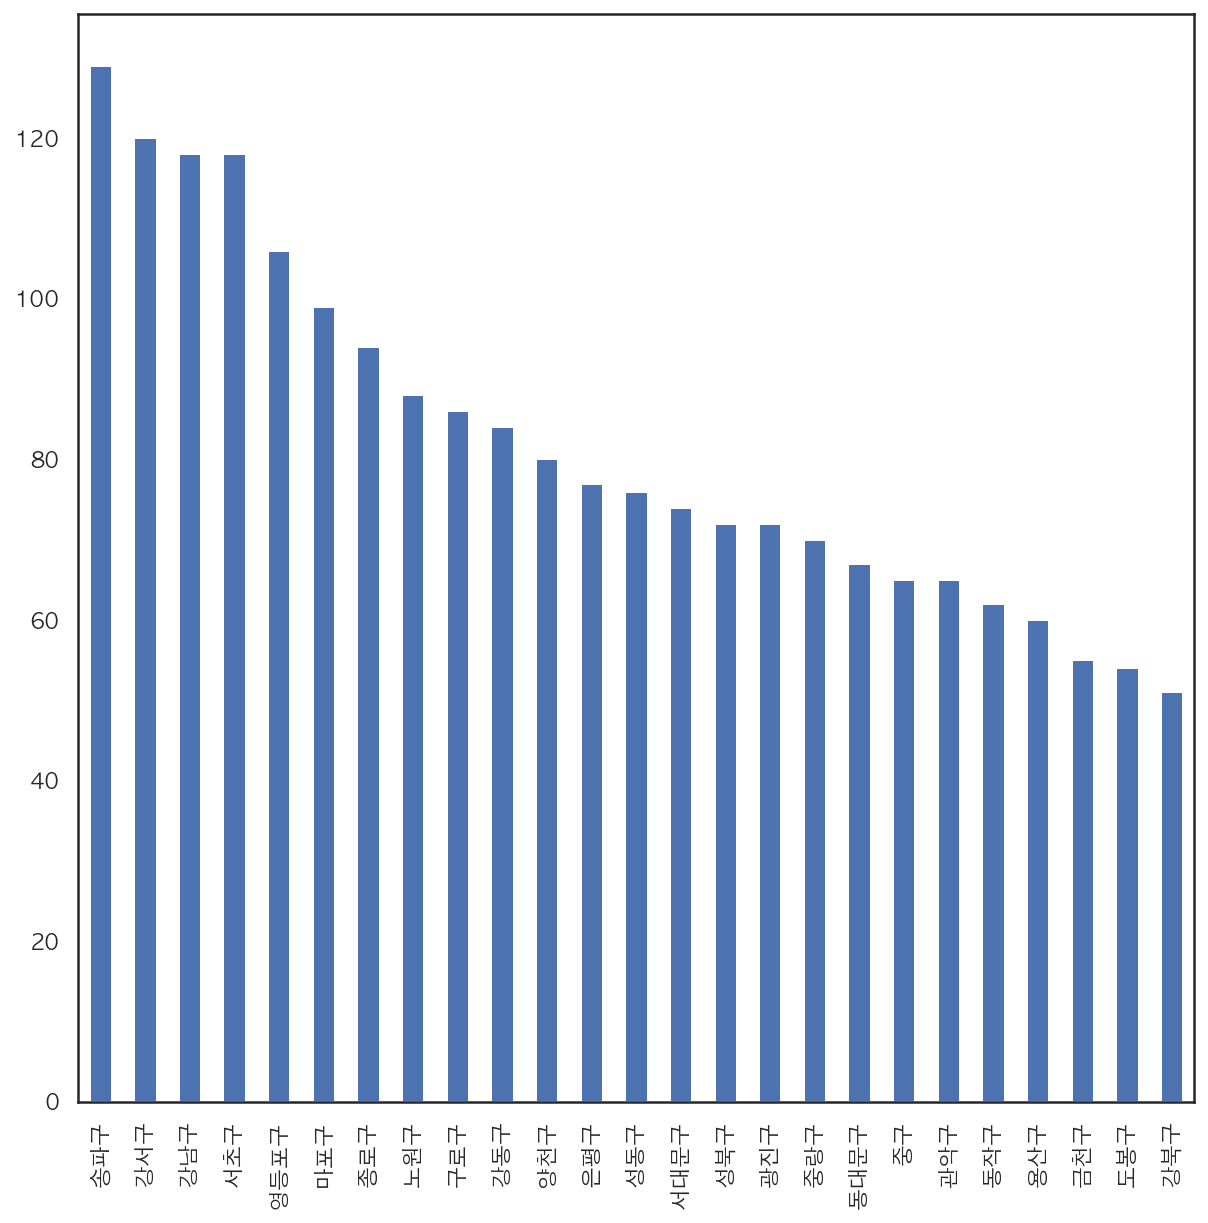

In [23]:
# 설치 장소 현황 그래프로 시각화
plt.figure(figsize=(10,10))
location.plot.bar()
plt.rc('font',family='AppleGothic')
plt.show()

In [24]:
sb1907_rent_station = sb1907['rental_station_name'].value_counts()[:21]
sb1907_rent_station

뚝섬유원지역 1번출구 앞              10317
여의나루역 1번출구 앞                9909
봉림교 교통섬                     8405
홍대입구역 2번출구 앞                7567
롯데월드타워(잠실역2번출구 쪽)           7349
건대입구역 사거리(롯데백화점)            6862
마곡나루역 5번출구 뒤편               6466
고속터미널역 8-1번, 8-2번 출구 사이     6442
안암로터리 버스정류장 앞               5824
동방1교                        5654
마포구민체육센터 앞                  5643
신도림역 1번 출구 앞                5601
양천향교역 7번출구앞                 5320
신대방역 2번 출구                  5160
가양역 8번출구                    4996
구로디지털단지역 앞                  4961
잠실새내역 5번 출구 뒤               4952
발산역 1번, 9번 인근 대여소           4838
당산역 10번출구 앞                 4832
자양사거리 광진아크로텔 앞              4662
CJ 드림시티                     4589
Name: rental_station_name, dtype: int64

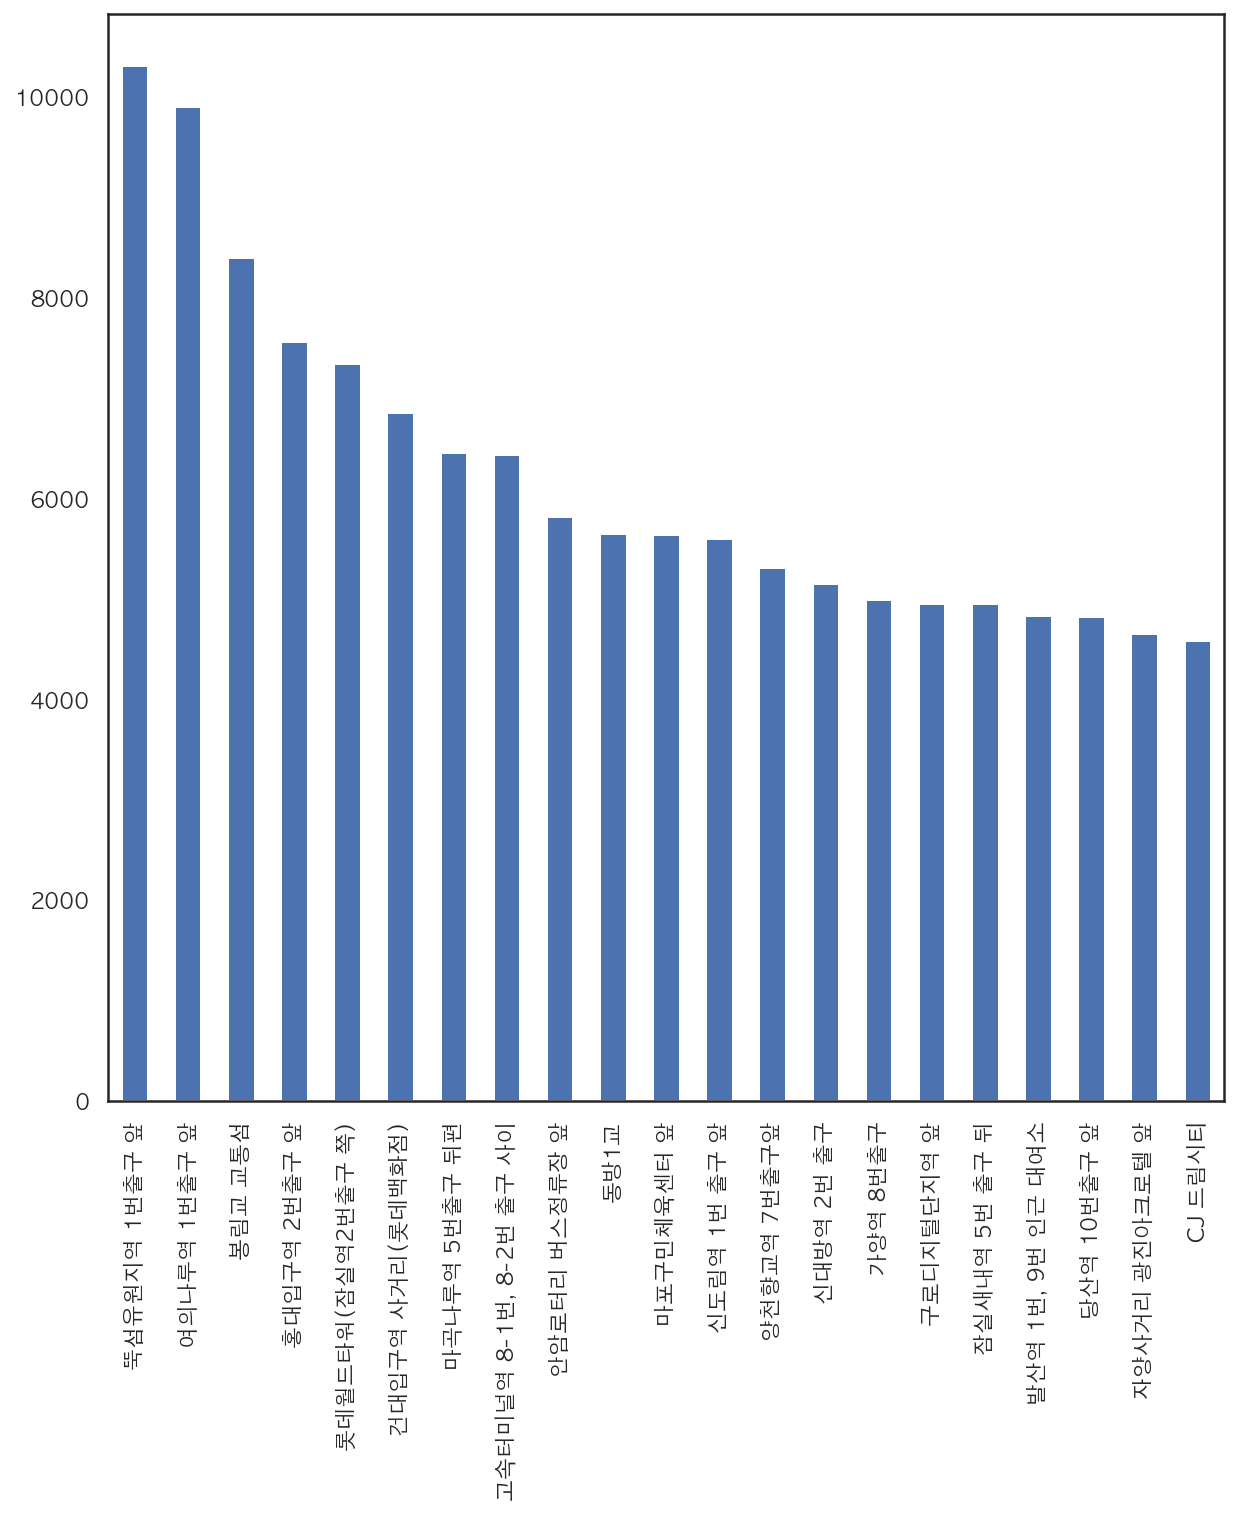

In [25]:
# 설치 장소 현황 그래프로 시각화
plt.figure(figsize=(10,10))
sb1907_rent_station.plot.bar()
plt.rc('font',family='AppleGothic')
plt.show()

In [26]:
sb1908_rent_station = sb1908['rental_station_name'].value_counts()[:21]
sb1908_rent_station

뚝섬유원지역 1번출구 앞              13397
여의나루역 1번출구 앞               12799
고속터미널역 8-1번, 8-2번 출구 사이     7919
봉림교 교통섬                     7918
홍대입구역 2번출구 앞                7451
롯데월드타워(잠실역2번출구 쪽)           7103
마포구민체육센터 앞                  7057
건대입구역 사거리(롯데백화점)            7002
마곡나루역 5번출구 뒤편               6583
안암로터리 버스정류장 앞               5590
잠실새내역 5번 출구 뒤               5586
양천향교역 7번출구앞                 5348
신도림역 1번 출구 앞                5311
동방1교                        5264
당산육갑문                       5155
당산역 10번출구 앞                 5139
CJ 드림시티                     4970
신대방역 2번 출구                  4933
가양역 8번출구                    4760
자양사거리 광진아크로텔 앞              4734
옥수역 3번출구                    4697
Name: rental_station_name, dtype: int64

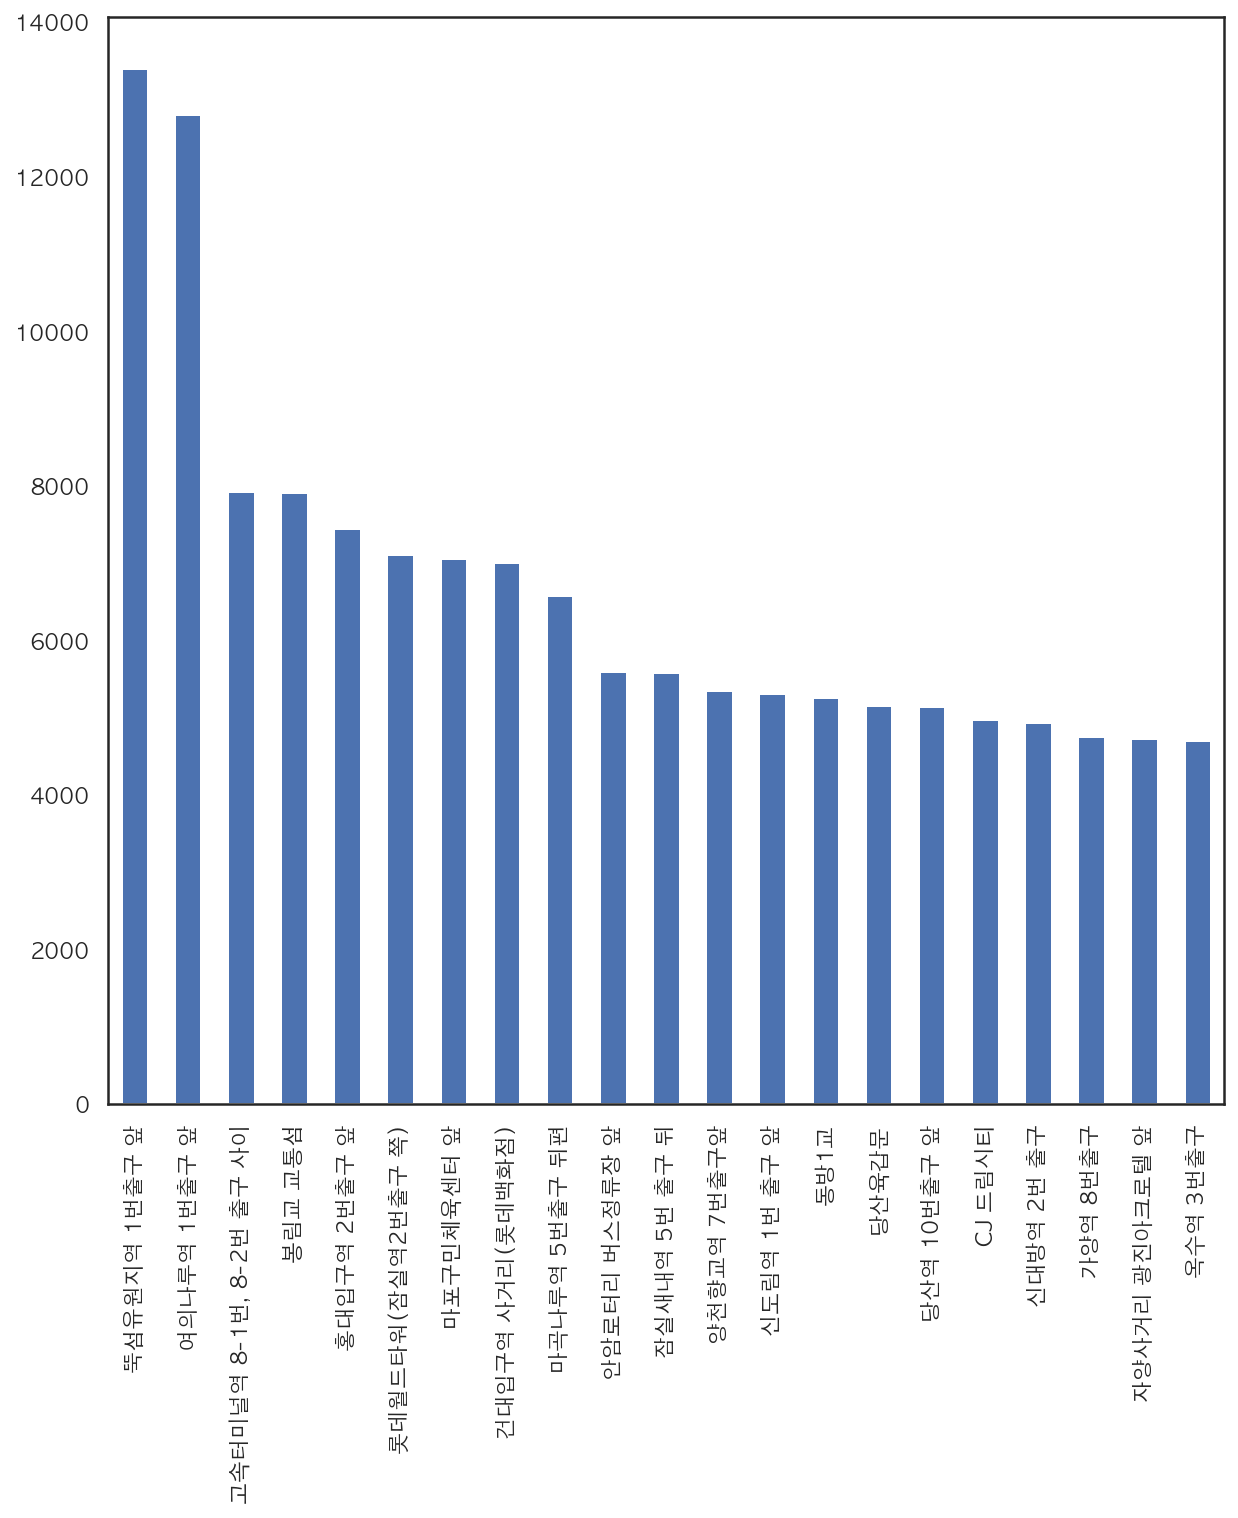

In [27]:
# 설치 장소 현황 그래프로 시각화
plt.figure(figsize=(10,10))
sb1908_rent_station.plot.bar()
plt.rc('font',family='AppleGothic')
plt.show()

In [28]:
sb2007_rent_station = sb2007['rental_station_name'].value_counts()[:21]
sb2007_rent_station

여의나루역 1번출구 앞               8462
뚝섬유원지역 1번출구 앞              8423
마포구민체육센터 앞                 5646
봉림교 교통섬                    5499
고속터미널역 8-1번, 8-2번 출구 사이    4145
당산육갑문                      4108
신대방역 2번 출구                 3848
청계천 생태교실 앞                 3814
옥수역 3번출구                   3759
마곡나루역 5번출구 뒤편              3538
양천향교역 7번출구앞                3536
신도림역 1번 출구 앞               3523
발산역 1번, 9번 인근 대여소          3499
건대입구역 사거리(롯데백화점)           3488
동방1교                       3417
롯데월드타워(잠실역2번출구 쪽)          3383
가양역 8번출구                   3349
CJ 드림시티                    3290
당산역 10번출구 앞                3235
IFC몰                       3074
구로디지털단지역 앞                 3037
Name: rental_station_name, dtype: int64

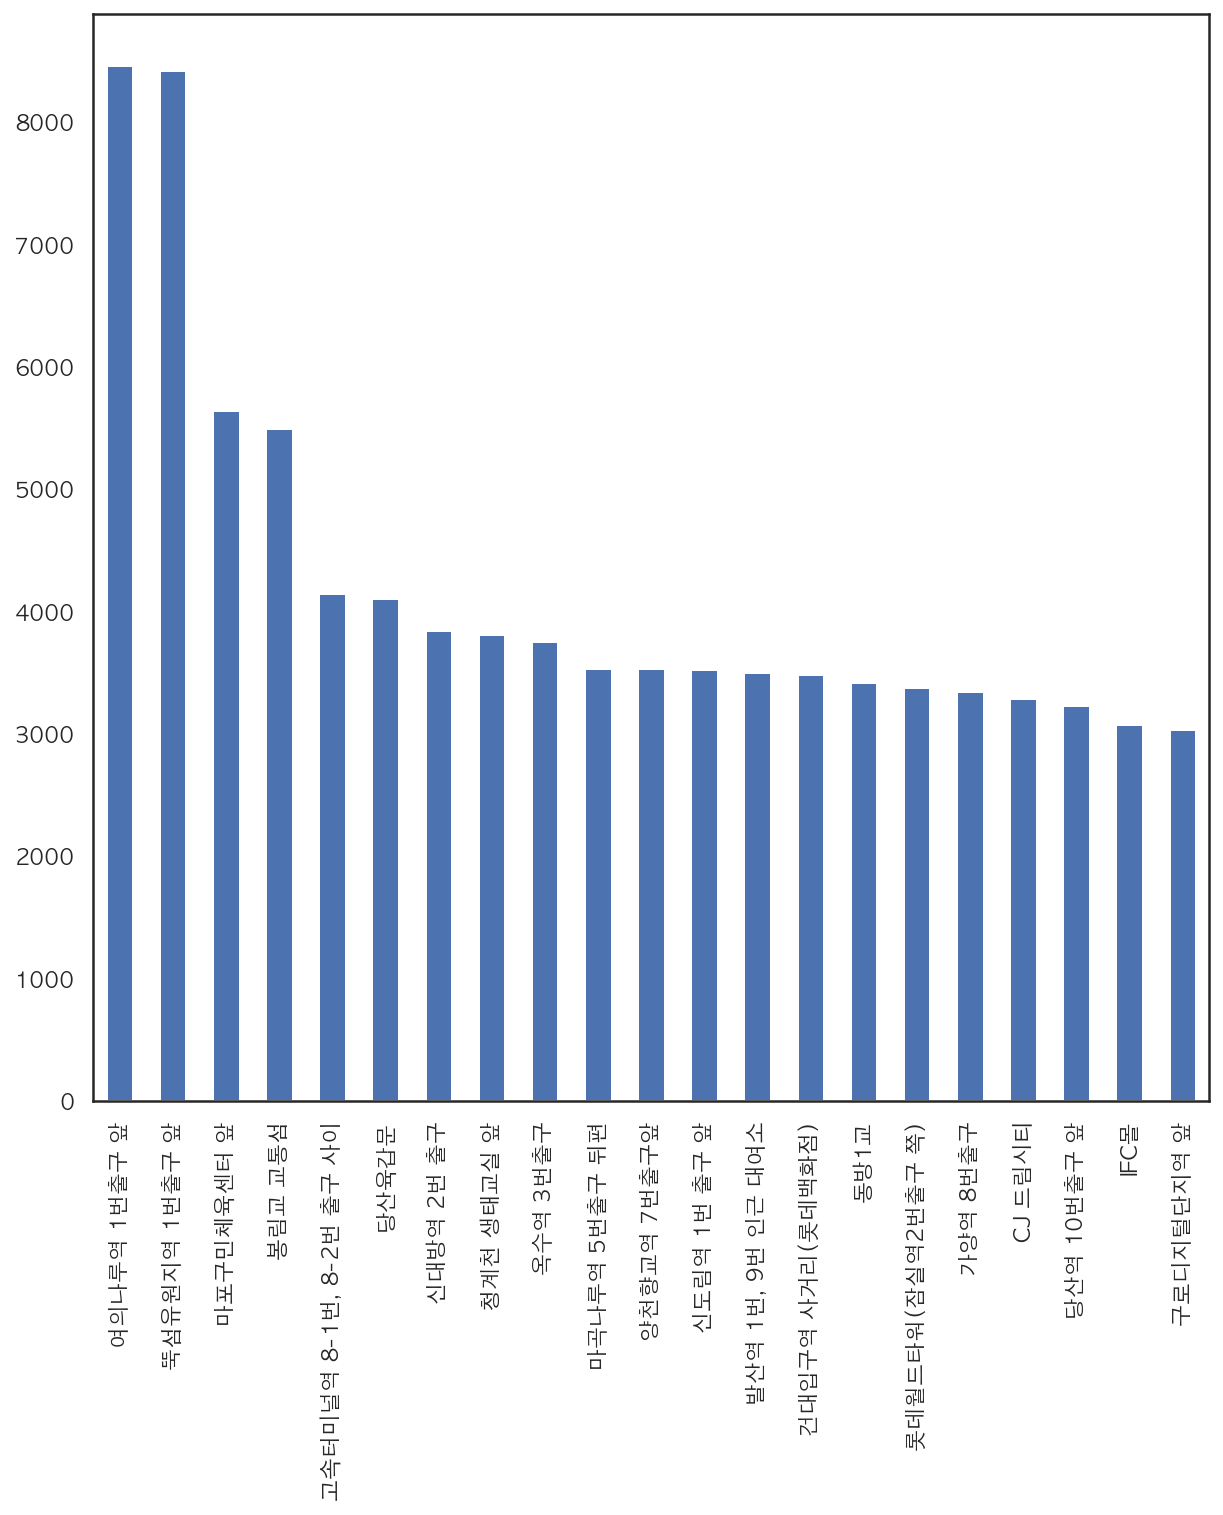

In [29]:
# 설치 장소 현황 그래프로 시각화
plt.figure(figsize=(10,10))
sb2007_rent_station.plot.bar()
plt.rc('font',family='AppleGothic')
plt.show()

In [30]:
sb2008_rent_station = sb2008['rental_station_name'].value_counts()[:21]
sb2008_rent_station

여의나루역 1번출구 앞                3531
뚝섬유원지역 1번출구 앞               3228
봉림교 교통섬                     2960
마포구민체육센터 앞                  2867
발산역 1번, 9번 인근 대여소           2676
양천향교역 7번출구앞                 2588
신대방역 2번 출구                  2293
당산역 10번출구 앞                 2246
홍대입구역 8번출구 앞                2238
마곡나루역 5번출구 뒤편               2216
가양역 8번출구                    2155
신방화역환승주차장                   2080
마곡엠밸리4단지 정문                 1932
신도림역 1번 출구 앞                1925
안암로터리 버스정류장 앞               1922
당산육갑문                       1891
발산역 6번출구옆(다이소앞)             1891
공릉역 1번 출구 앞                 1886
영등포구청역 1번출구                 1885
증미역 3번출구뒤(등촌두산위브센티움오피스텔)    1853
마곡나루역 2번 출구                 1838
Name: rental_station_name, dtype: int64

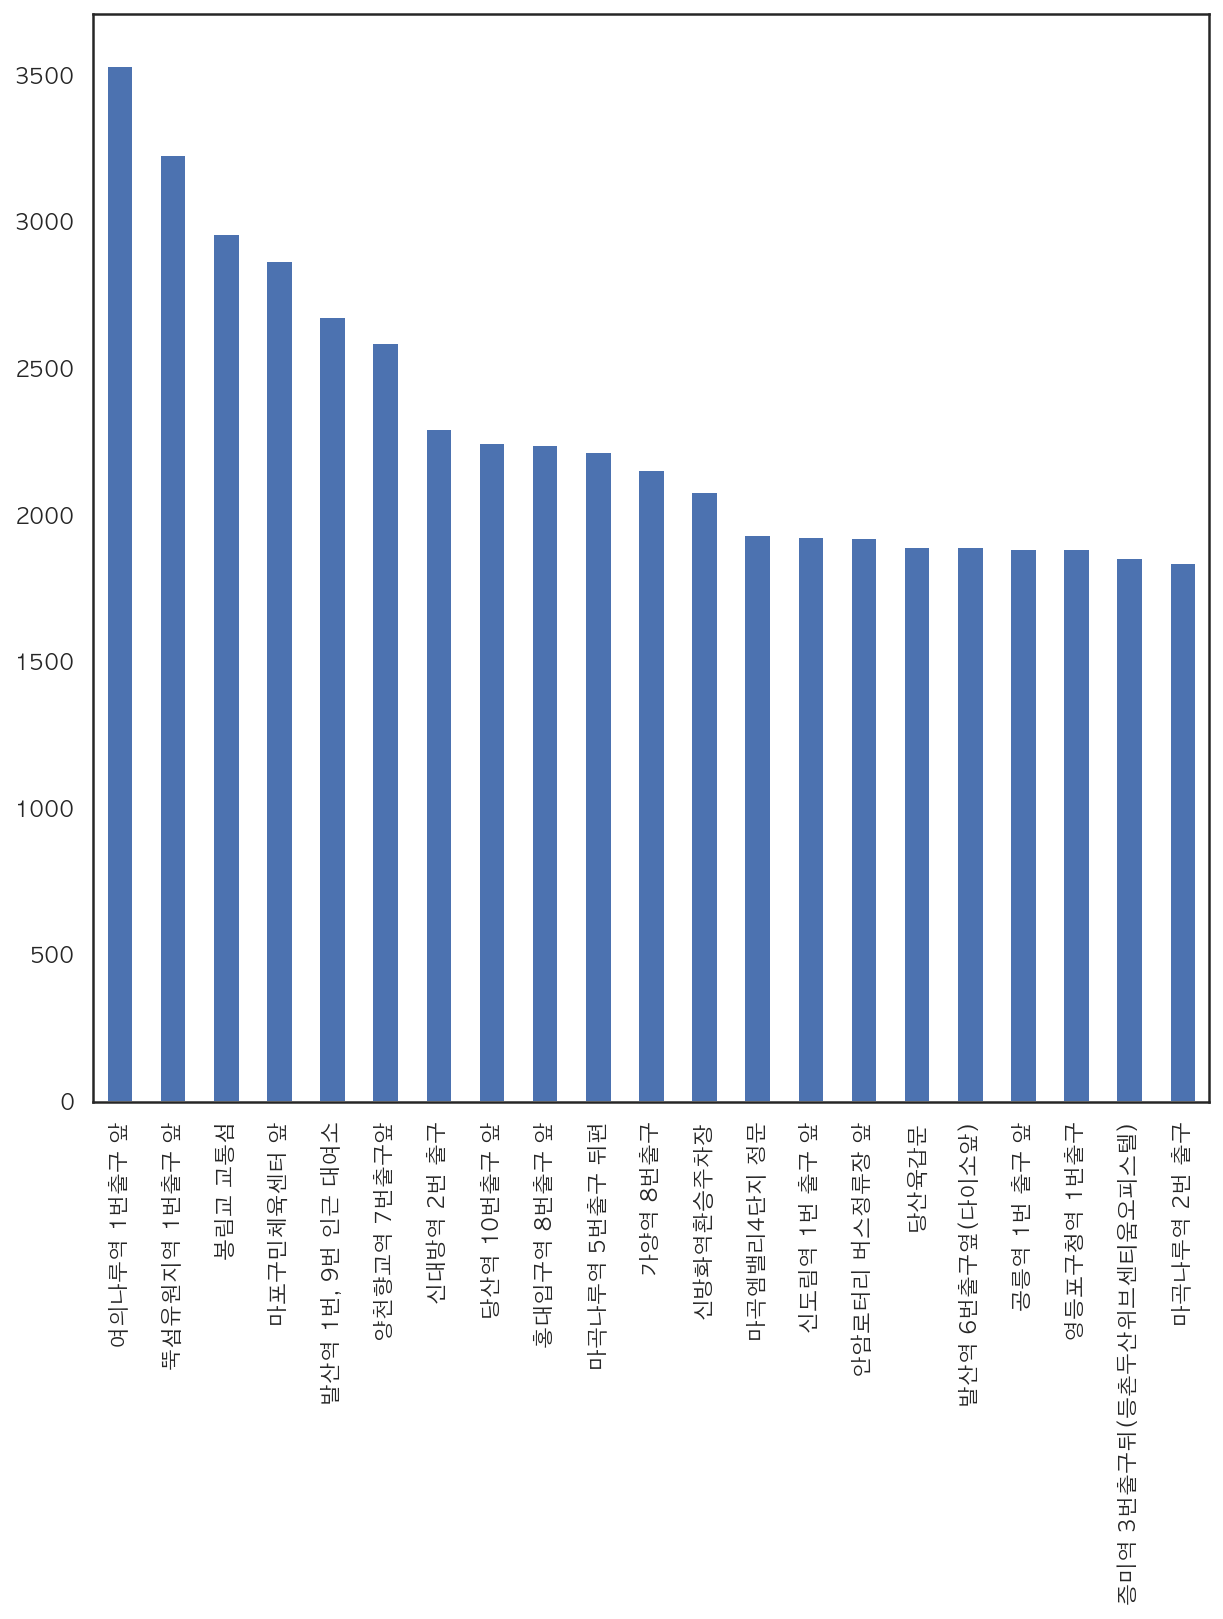

In [31]:
# 설치 장소 현황 그래프로 시각화
plt.figure(figsize=(10,10))
sb2008_rent_station.plot.bar()
plt.rc('font',family='AppleGothic')
plt.show()

In [34]:
mapo = station.loc[station['location'] == '마포구']
mapo

,station_num,station_name,location,longitude,latitude
920,101.0,(구)합정동 주민센터,마포구,37.549561,126.905754
921,102.0,망원역 1번출구 앞,마포구,37.555649,126.910629
922,103.0,망원역 2번출구 앞,마포구,37.554951,126.910835
923,104.0,합정역 1번출구 앞,마포구,37.550629,126.914986
924,105.0,합정역 5번출구 앞,마포구,37.550007,126.914825
925,106.0,합정역 7번출구 앞,마포구,37.548645,126.912827
926,107.0,신한은행 서교동금융센터점 앞,마포구,37.557510,126.918503
927,108.0,서교동 사거리,마포구,37.552746,126.918617
928,109.0,제일빌딩 앞,마포구,37.547691,126.919983
929,111.0,상수역 2번출구 앞,마포구,37.547871,126.923531


In [42]:
import folium
from folium.plugins import MarkerCluster
import folium.features 

map = folium.Map(location=[g['longitude'].mean(), g['latitude'].mean()], zoom_start=12)

for n in g.index:
    # 팝업에 들어갈 텍스트를 지정 
    popup_name = g.loc[n, "station_name"]
    # 스테이션마다 아이콘 지정 
    if station.loc[n, 'station_name']:
        icon_color = "green"
    else:
        icon_color = "blue"
        
    folium.features.Marker(
        location=[g.loc[n, 'longitude'], g.loc[n, 'latitude']],
        radius=3,
        popup=popup_name,
        color=icon_color,
        fill=True,
        fill_color=icon_color
    ).add_to(map)
    
map

In [44]:
map = folium.Map(location=[G['longitude'].mean(), G['latitude'].mean()], zoom_start=12)

for n in G.index:
    # 팝업에 들어갈 텍스트를 지정 
    popup_name = G.loc[n, "station_name"]
    # 스테이션마다 아이콘 지정 
    if station.loc[n, 'station_name']:
        icon_color = "green"
    else:
        icon_color = "blue"
        
    folium.features.Marker(
        location=[G.loc[n, 'longitude'], G.loc[n, 'latitude']],
        radius=3,
        popup=popup_name,
        color=icon_color,
        fill=True,
        fill_color=icon_color
    ).add_to(map)
    
map

In [36]:
hapjung_jumin = sb1907.loc[sb1907["rental_station_name"] == '(구)합정동 주민센터']
hapjung_jumin

,rental_station_num,rental_station_name,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,bicycle_type_num
20760,101,(구)합정동 주민센터,184,SK망원동주유소 건너편,14,1310.0,2019-07-01,10:35:26,10:50:02,1
29619,101,(구)합정동 주민센터,152,마포구민체육센터 앞,8,1170.0,2019-07-01,06:48:38,06:57:53,1
29692,101,(구)합정동 주민센터,152,마포구민체육센터 앞,22,4020.0,2019-07-01,00:01:09,00:24:24,1
30107,101,(구)합정동 주민센터,748,목동운동장,52,8500.0,2019-07-01,22:10:48,23:04:56,1
34096,101,(구)합정동 주민센터,199,서울 월드컵 경기장,17,3560.0,2019-07-01,06:26:07,06:43:59,1
34784,101,(구)합정동 주민센터,151,망원1동주민센터,5,950.0,2019-07-01,17:31:56,17:38:21,1
38631,101,(구)합정동 주민센터,2210,반포1동 주민센터 앞,58,14200.0,2019-07-01,19:14:21,20:18:17,1
41906,101,(구)합정동 주민센터,153,성산2교 사거리,19,3810.0,2019-07-01,18:52:25,19:12:31,1
42021,101,(구)합정동 주민센터,153,성산2교 사거리,16,2630.0,2019-07-01,11:32:31,11:49:11,1
45916,101,(구)합정동 주민센터,267,삼성화재 사옥 옆,11,2230.0,2019-07-01,08:45:19,08:56:59,1


In [40]:
hapjung_jumin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014 entries, 20760 to 2082477
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rental_station_num   1014 non-null   int64  
 1   rental_station_name  1014 non-null   object 
 2   return_station_num   1014 non-null   int64  
 3   return_station_name  1014 non-null   object 
 4   using_time           1014 non-null   int64  
 5   using_distance       1014 non-null   float64
 6   rental_day           1014 non-null   object 
 7   rental_time          1014 non-null   object 
 8   return_day           1014 non-null   object 
 9   bicycle_type_num     1014 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 87.1+ KB


In [39]:
hapjung_jumin['return_station_name'].value_counts()

(구)합정동 주민센터                152
합정역 7번출구 앞                  94
합정역 1번출구 앞                  70
마포구민체육센터 앞                  67
망원역 2번출구 앞                  42
망원1동주민센터                    35
극동방송국 앞                     31
망원2빗물펌프장 앞                  31
제일빌딩 앞                      30
합정역 5번출구 앞                  27
홍대입구역 2번출구 앞                24
서울역 서부교차로2                  17
삼성화재 사옥 옆                   17
SK망원동주유소 건너편                15
서울 월드컵 경기장                  15
망원역 1번출구 앞                  15
서교동 사거리                     15
상수역 2번출구 앞                  14
마포구청역                       14
베르가모앞                       12
DMC산학협력연구센터 앞               12
신한은행 서교동금융센터점 앞             11
국회의사당역 3번출구 옆               10
성산2교 사거리                     9
선유도역 3번출구 앞                  8
명지대학교 도서관                    7
KB국민은행 염창역 지점 앞              6
그랜드컨벤션센터 앞                   6
서강대 남문 옆                     6
홍대입구역 8번출구 앞                 5
마포중앙도서관                      5
월드컵경기장역 3번출구 옆               4
신대방역 2번 

In [43]:
G = station.loc[station['location'] == '강서구']
G

,station_num,station_name,location,longitude,latitude
1099,1101.0,개화동상사마을종점 버스정류장,강서구,37.581612,126.798599
1100,1102.0,방화사거리 마을버스 버스정류장,강서구,37.573643,126.811806
1101,1103.0,방화역 4번출구앞,강서구,37.577221,126.812195
1102,1105.0,방화근린공원,강서구,37.581623,126.812653
1103,1106.0,신방화사거리,강서구,37.573032,126.816452
1104,1108.0,공항시장역 2번출구 뒤,강서구,37.563560,126.810150
1105,1109.0,공항시장역 4번출구,강서구,37.563347,126.810486
1106,1110.0,공항중학교앞,강서구,37.562683,126.816238
1107,1111.0,마곡엠밸리6_7단지 마곡중학교,강서구,37.566982,126.821800
1108,1112.0,마곡엠밸리4단지 정문,강서구,37.568577,126.824776


In [41]:
g = station.loc[station['location'] == '금천구']
g

,station_num,station_name,location,longitude,latitude
1305,1804.0,독산역 2번출구 자전거주차장,금천구,37.466530,126.888718
1306,1805.0,서울디지털운동장 앞,금천구,37.482288,126.877769
1307,1806.0,에이스하이엔드타워9차 앞,금천구,37.486214,126.878639
1308,1808.0,에이스하이엔드타워8차 앞,금천구,37.473209,126.884941
1309,1809.0,LG전자 별관동(호서대 벤처타워 맞은편),금천구,37.470779,126.885155
1310,1812.0,갑을그레이트밸리 앞,금천구,37.479031,126.887299
1311,1814.0,두산위브아파트 옆 상가건물 앞,금천구,37.474220,126.894127
1312,1816.0,금천폭포공원 앞,금천구,37.446861,126.903831
1313,1819.0,금천구청 앞 자전거거치대,금천구,37.456478,126.895927
1314,1820.0,신한은행 시흥대로금융센터지점,금천구,37.443340,126.903358


In [45]:
g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 1305 to 1359
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_num   55 non-null     float64
 1   station_name  55 non-null     object 
 2   location      55 non-null     object 
 3   longitude     55 non-null     float64
 4   latitude      55 non-null     float64
dtypes: float64(3), object(2)
memory usage: 4.6+ KB


In [46]:
G.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 1099 to 1218
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_num   120 non-null    float64
 1   station_name  120 non-null    object 
 2   location      120 non-null    object 
 3   longitude     120 non-null    float64
 4   latitude      120 non-null    float64
dtypes: float64(3), object(2)
memory usage: 9.7+ KB


In [67]:
data = pd.read_csv('datas/report.txt', sep = "\t", engine='python')
data

,기간,구분,구분.1,전체,남자,여자
0,2018,서울시,서울시,28.8,37.6,20.4
1,2018,생애주기별,19~29세,21.0,31.3,10.6
2,2018,생애주기별,30~44세,29.4,44.3,13.9
3,2018,생애주기별,45~64세,31.2,39.8,23.2
4,2018,생애주기별,65세 이상,31.5,28.3,34.3
5,2018,교육수준별Ⅰ(30~64세),중졸이하,34.3,34.1,34.4
6,2018,교육수준별Ⅰ(30~64세),고졸,32.0,41.8,24.1
7,2018,교육수준별Ⅰ(30~64세),대졸이상,29.0,42.7,13.6
8,2018,교육수준별Ⅱ(65세 이상),초졸이하,36.6,26.7,40.6
9,2018,교육수준별Ⅱ(65세 이상),중졸,26.7,27.0,26.4


In [68]:
data = data.drop([1,2,3,4,5,6,7,8,9,10,11,12,13])
data

,기간,구분,구분.1,전체,남자,여자
0,2018,서울시,서울시,28.8,37.6,20.4
14,2018,종로구,종로구,32.4,40.1,25.0
15,2018,중구,중구,27.6,34.4,20.8
16,2018,용산구,용산구,24.7,31.8,18.1
17,2018,성동구,성동구,29.5,42.1,17.3
18,2018,광진구,광진구,30.5,39.8,21.8
19,2018,동대문구,동대문구,30.3,38.3,22.2
20,2018,중랑구,중랑구,34.2,39.4,29.0
21,2018,성북구,성북구,32.3,40.4,24.6
22,2018,강북구,강북구,28.5,34.4,22.6


In [73]:
data1 = data.drop(['구분.1'], axis=1)
data1

,기간,구분,전체,남자,여자
0,2018,서울시,28.8,37.6,20.4
14,2018,종로구,32.4,40.1,25.0
15,2018,중구,27.6,34.4,20.8
16,2018,용산구,24.7,31.8,18.1
17,2018,성동구,29.5,42.1,17.3
18,2018,광진구,30.5,39.8,21.8
19,2018,동대문구,30.3,38.3,22.2
20,2018,중랑구,34.2,39.4,29.0
21,2018,성북구,32.3,40.4,24.6
22,2018,강북구,28.5,34.4,22.6


In [75]:
data = data1.reset_index(drop=True)
data

,기간,구분,전체,남자,여자
0,2018,서울시,28.8,37.6,20.4
1,2018,종로구,32.4,40.1,25.0
2,2018,중구,27.6,34.4,20.8
3,2018,용산구,24.7,31.8,18.1
4,2018,성동구,29.5,42.1,17.3
5,2018,광진구,30.5,39.8,21.8
6,2018,동대문구,30.3,38.3,22.2
7,2018,중랑구,34.2,39.4,29.0
8,2018,성북구,32.3,40.4,24.6
9,2018,강북구,28.5,34.4,22.6
